In [102]:
"""
Grover Mixer QAOA (GM-QAOA) Variance and Expectation of the loss function.

This module provides functions for constructing QAOA circuits with Grover mixers (GM-QAOA). The code was inspired by 
"Provable avoidance of barren plateaus for the Quantum Approximate Optimization Algorithm with Grover mixers."
arXiv:2509.10424

Author: Matthew Nuyten
Date: 2025-10-04
"""

import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
import numpy as np

import time
import itertools as it
from typing import List, Tuple
from matplotlib.ticker import LogLocator, MaxNLocator, AutoLocator

import os


# ================================================================
# Hamiltonians
# ================================================================

def maxcut_hamiltonian(edges: List[Tuple[int, int]], normalize: bool = True) -> qml.Hamiltonian:
    """
    The problem Hamiltonian we want to maximize
    H_P = sum_{(i,j) in E} 0.5*(1 - Z_i Z_j) 

    Leave normalize=True.
    """
    m = len(edges)
    coeffs = []
    ops = []
    scale = 1.0 / m if (normalize and m > 0) else 1.0

    # Single global identity shift: 0.5 * m  -> coefficient (0.5*m)*scale
    if m > 0:
        coeffs.append(0.5 * m * scale)
        ops.append(qml.Identity(wires=0))  # global shift (PennyLane will lift this)

    for (i, j) in edges:
        coeffs.append(-0.5 * scale)  # -0.5 Z_i Z_j
        ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

def x_mixer_hamiltonian(n_wires: int) -> qml.Hamiltonian:
    """Return the standard QAOA mixer Hamiltonian:
    Transverse field mixer, X-mixer, H = sum_i X_i."""
    
    coeffs = [1.0] * n_wires
    ops = [qml.PauliX(i) for i in range(n_wires)]
    return qml.Hamiltonian(coeffs, ops)

# ================================================================
# Grover Mixer
# ================================================================


def phase_on_zero_state(beta, wires: List[int]):
    controls = wires[:-1]
    target = wires[-1]
    for w in wires:
        # apply flip   
        qml.PauliX(wires=w)
    # Apply a multi-controlled PhaseShift of e^{-i*beta} on the last qubit
    qml.ctrl(qml.PhaseShift, control=controls)(-beta, target)
    for w in wires:
        # Undo flip
        qml.PauliX(wires=w)

def grover_mixer_unitary(beta, wires: List[int]):
    """Apply Grover mixer U_M(beta) = H^{⊗n} * exp(-i beta |0^n><0^n|) * H^{⊗n}."""
    for w in wires:
        qml.Hadamard(wires=w)
    phase_on_zero_state(beta, wires)
    for w in wires:
        qml.Hadamard(wires=w)

# ================================================================
# QAOA Circuits
# ================================================================

def qaoa_layer(params, cost_h: qml.Hamiltonian, mixer: str, n_wires: int):
    """Single QAOA layer: cost evolution then mixer evolution."""
    gamma, beta = params
    qml.ApproxTimeEvolution(cost_h, gamma, 1)
    if mixer == "standard":
        qml.ApproxTimeEvolution(x_mixer_hamiltonian(n_wires), beta, 1)
    elif mixer == "grover":
        grover_mixer_unitary(beta, wires=list(range(n_wires)))
    else:
        raise ValueError(f"Unknown mixer: {mixer}")

def qaoa_circuit(params, p: int, cost_h: qml.Hamiltonian, mixer: str, n_wires: int):
    """Full QAOA circuit with p layers."""
    for w in range(n_wires):
        qml.Hadamard(wires=w)
    for i in range(p):
        qaoa_layer(params[i], cost_h, mixer, n_wires)


### Data ###

# ================================================================
# Graph Utilities for Discrete Optimization
# ================================================================
def random_connected_graph(n_wires: int, rng: np.random.Generator) -> List[Tuple[int, int]]:
    """Generate a random connected graph with n_wires nodes and return list of edges."""
    while True:
        G = nx.gnp_random_graph(n_wires, seed=int(rng.integers(0, 1000)), p=0.5)
        if nx.is_connected(G):
            return list(G.edges())
        
# ================================================================
# Theoretical Loss Function for MaxCut
# ================================================================

def maxcut_objective_values(n_wires: int, edges: List[Tuple[int, int]]):
    """Compute distinct, nonzero MaxCut objective function values for a graph."""
    values = []
    for bits in it.product([0, 1], repeat=n_wires):
        cut_value = sum(bits[u] != bits[v] for u, v in edges)
        if cut_value != 0:
            values.append(cut_value)
    return sorted(set(values))

def theoretical_variance(edges: List[Tuple[int, int]], coeff: float = 1.0, n_wires: int = 8):
    """Compute theoretical variance from distinct MaxCut values."""
    lambdas = maxcut_objective_values(n_wires, edges)
    d = len(lambdas)
    total = sum((lambdas[i] - lambdas[j]) ** 2 for i in range(d) for j in range(i + 1, d))
    result = coeff * total / (d**2 * (d + 1))
    return result, lambdas


def theoretical_variance_range_vs_n(n_min: int = 4, n_max: int = 16, n_graphs: int = 5, rng: np.random.Generator = None):
    """Compute the min/max theoretical variance over n_min <= n qubits <= n_max. 
    
    Returns:
        dict[n] = {"min": float, "max": float}
    """
    if rng is None:   
        rng = np.random.default_rng()
    results = {}
    for n in range(n_min, n_max + 1, 2):
        vmin, vmax = min_max_theoretical_variance(n, n_graphs=n_graphs, rng=rng)
        if vmin is not None:
            results[n] = {"min": vmin, "max": vmax}
    return results

# ================================================================
# Empirical Variance
# ================================================================

def empirical_variance(
    n_wires: int,
    edges: List[Tuple[int, int]],
    max_depth: int = 30,
    mixer: str = "grover",
    n_param_samples: int = 50,
    rng: np.random.Generator = None,
    device_name: str = "default.qubit",
    gamma_range: Tuple[float, float] = (0.0, 2*np.pi),
    beta_range: Tuple[float, float] = (0.0, np.pi),
):
    """
    Compute expectation values and variances for depth 1...max_depth
    reusing the same random parameters and random graphs.

    Args:
        n_wires (int): number of qubits
        edges (list[tuple]): graph edges
        max_depth (int): maximum QAOA depth p
        mixer (str): "standard" or "grover"
        n_param_samples (int): number of random parameter samples
        rng (np.random.Generator): random generator
        device_name (str): PennyLane's "default.qubit" or "lightning.qubit"
        gamma_range (tuple): sampling range for gammas
        beta_range (tuple): sampling range for betas

    Returns:
        dict: res[p] = {
            "variance": float,
            "expectations": np.array,
            "mean": float,
            "time": float
        }
    """
    if rng is None:
        rng = np.random.default_rng()

    # build problem Hamiltonian H_P
    cost_h = maxcut_hamiltonian(edges, normalize=True)
    
    dev = qml.device(device_name, wires=n_wires)

    @qml.qnode(dev)
    def expval_circuit(params, depth):
        """Run QAOA up to depth layers and return expectation value of the loss function."""
        qaoa_circuit(params[:depth], depth, cost_h, mixer=mixer, n_wires=n_wires)
        return qml.expval(cost_h)
        
    # Pre-sample parameters for all depths
    gammas = rng.uniform(gamma_range[0], gamma_range[1],
                         size=(n_param_samples, max_depth))
    betas = rng.uniform(beta_range[0], beta_range[1],
                        size=(n_param_samples, max_depth))
    params = np.stack([gammas, betas], axis=-1)  # shape (n_samples, max_depth, 2)
    
    results = {}
    for p in range(1, max_depth + 1):
        t0 = time.time()
        vals = [expval_circuit(params[i, :p], p) for i in range(n_param_samples)]
        t1 = time.time()

        results[p] = {
            "variance": float(np.var(vals, ddof=0)),
            "expectations": np.array(vals),
            "mean": float(np.mean(vals)),
            "time": t1 - t0,
        }

    return results

def stats_vs_depth(
    n_wires: int,
    n_graphs: int = 5,
    max_depth: int = 30,
    mixer: str = "grover",
    n_param_samples: int = 100,
    rng: np.random.Generator = None,
    gamma_range: Tuple[float, float] = (0.0, 2*np.pi),
    beta_range: Tuple[float, float] = (0.0, np.pi),
):
    """
    Compute variance and expectation vs depth for multiple random graphs, reusing computation across depths.

    Returns:
        dict: results[p][g] = {
            "variance": float,
            "expectation": float,
            "time": float
        }
    """
    if rng is None:
        rng = np.random.default_rng()

    results = {p: {} for p in range(1, max_depth + 1)}

    for g in range(n_graphs):
        edges = random_connected_graph(n_wires, rng=rng)
        print(f"\nGraph {int(g+1)}: edges={edges}")

        # progressive empirical calculation
        res = empirical_variance(
            n_wires=n_wires,
            edges=edges,
            max_depth=max_depth,
            mixer=mixer,
            n_param_samples=n_param_samples,
            rng=rng,
            gamma_range=gamma_range,
            beta_range=beta_range,
        )

        for p in range(1, max_depth + 1):
            var = res[p]["variance"]
            mean = res[p]["mean"]     
            t = res[p]["time"]

            results[p][g] = {"variance": var, "expectation": mean, "time": t}
            print(f"  depth={p:2d} | var={var:.6f} | ⟨H_P⟩={mean:.6f} | time={t:.2f}s")

    return results


def empirical_variance_range_vs_n(
    n_min: int = 4,
    n_max: int = 10,
    n_graphs: int = 5,
    max_depth: int = 30,
    n_param_samples: int = 100,
    rng: np.random.Generator = None,
):
    """
    Estimate the lower and upper bound of the variance as a function of n.
    For each n, sample multiple random graphs, compute variances across depths,
    record the minimum (maximum) variance per graph, and then take the minimum (maximum) across graphs.
    
    Returns:
        dict[n] = {
            "min_over_graphs": float,
            "mins_per_graph": list,
            "max_over_graphs": float,
            "maxs_per_graph": list,
        }
    """
    if rng is None:
        rng = np.random.default_rng()
    
    results = {}
    for n in range(n_min, n_max + 1):
        mins_per_graph = []
        maxs_per_graph = []
        for g in range(n_graphs):
            edges = random_connected_graph(n, rng=rng)
            res = empirical_variance(
                n_wires=n,
                edges=edges,
                max_depth=max_depth,
                rng=rng,
                n_param_samples=n_param_samples,
            )
            # take min/max variance across depths for this graph
            min_var_graph = min(res[p]["variance"] for p in res)
            mins_per_graph.append(min_var_graph)
            max_var_graph = max(res[p]["variance"] for p in res)
            maxs_per_graph.append(max_var_graph)
        
        results[n] = {
            "min_over_graphs": float(np.min(mins_per_graph)),
            "mins_per_graph": mins_per_graph,
            "max_over_graphs": float(np.max(maxs_per_graph)),
            "maxs_per_graph": maxs_per_graph,
        }
        print(f"n={n}: min variance across {n_graphs} graphs = {results[n]['min_over_graphs']:.3e}")
        print(f"n={n}: max variance across {n_graphs} graphs = {results[n]['max_over_graphs']:.3e}")
    
    return results
    
### Plotting ###

# ================================================================
# Utilities
# ================================================================

def ensure_dir(path: str):
    """Create a directory if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)


def save_plot(fig, fig_path: str, filename: str, show: bool = True):
    """Save matplotlib figure to file and optionally display it."""
    ensure_dir(fig_path)
    filepath = os.path.join(fig_path, filename)
    fig.savefig(filepath, dpi=300, bbox_inches="tight")
    print(f"Saved plot: {filepath}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)

# Define a list of marker styles (reused for same 5 random graphs)
marker_styles = it.cycle(['h','+','x','o','s',])


# ================================================================
# Results
# ================================================================

# Results from stats_vs_depth()
def plot_variance_data(results, n_wires: int,  n_param_samples: int =None, 
                       outdir: str = "./figures", show: bool = True):
    """
    For fixed n vertices:
    Plot variance vs depth curves, per graph instance.
    Saves as PNG and PDF.
    """
    ensure_dir(outdir)
    fig, ax = plt.subplots(figsize=(3.5, 3.0))

    for g in range(len(next(iter(results.values())))):
        depths = sorted(results.keys())
        current_marker = next(marker_styles)
        variances = [results[p][g]["variance"] for p in depths]
        ax.plot(depths, variances, marker=current_marker, label=f"G {int(g+1)}")

    ax.set_xlabel(r"Depth $p$")
    ax.set_xlim(left=0)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_ylabel("Variance of the loss function")
    ax.set_yscale("log")
    ax.set_ylim([4e-4, 1e-2])
    custom_ticks = [5e-4, 1e-3,5e-3, 1e-2]
    custom_labels = [
        r"$5 \times 10^{-4}$",
        r"$10^{-3}$",
        r"$5 \times 10^{-3}$",
        r"$10^{-2}$",
    ]
    ax.set_yticks(custom_ticks, labels=custom_labels)
    
    #ax.set_title("Variance vs Depth")
    ax.legend(fontsize=8)
    ax.grid(True, which='both')
    # Overlay reference 1/3 * n^-4
    #ref_value = 1/3 * (n_wires ** -4)
    #ax.axhline(y=ref_value, color='grey', linestyle='-.', linewidth=2)
    
    save_plot(fig, outdir, f"variance_vs_depth_n_{n_wires}_{n_param_samples}_params_final.png", show=show)
    
# Results from stats_vs_depth()
def plot_expectation_data(results, n_wires: int, n_param_samples: int =None, 
                          outdir: str = "./figures", show: bool = True):
    """
    For fixed n vertices:
    Plot expectation value vs depth curves, per graph instance.
    Saves as PNG and PDF.
    """
    ensure_dir(outdir)
    fig, ax = plt.subplots(figsize=(3.5, 3.0))

    for g in range(len(next(iter(results.values())))):
        depths = sorted(results.keys())
        current_marker = next(marker_styles)
        expectations = [results[p][g]["expectation"] for p in depths]
        ax.plot(depths, expectations, marker=current_marker, label=f"G {int(g+1)}")

    ax.set_xlabel(r'Depth $p$')
    ax.set_xlim(left=0)
    ax.yaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel("Expectation of the loss function")
   # ax.set_yscale("log")
   # ax.set_title("Expectation vs Depth")
    ax.legend(fontsize=8)
    ax.grid(True, which='both')

    save_plot(fig, outdir, f"expectation_vs_depth_n_{n_wires}_{n_param_samples}_params.png", show=show)

# Plots results from empirical_variance_range_vs_n()
def plot_variance_range(results, max_depth: int = 30, n_param_samples: int = None,
                        outdir: str = "./figures", ref_scale: float = 1.0, show: bool = True):
    """
    For use with Plot min/max empirical variances across n, with an overlay reference curve ~ n^-4.
    Saves as PNG and PDF.
    """
    ensure_dir(outdir)
    ns = sorted(results.keys())
    mins = [results[n]["min_over_graphs"] for n in ns]
    maxs = [results[n]["max_over_graphs"] for n in ns]

    fig, ax = plt.subplots(figsize=(3.5, 3.0))
    ax.fill_between(ns, mins, maxs, color="skyblue", alpha=0.4, label="Variance range")
    ax.plot(ns, mins, "c--", label="Minimum")
    ax.plot(ns, maxs, "c-", label="Maximum")

    # Overlay reference curve c * n^-4
    ref_curve = [ref_scale * (n ** -4) for n in ns]
    ax.plot(ns, ref_curve,'m-.', linewidth=2, label="Analytical lower bound")

    ax.set_xlabel(r"$n$ qubits")
    ax.set_ylabel("Variance of the loss function")
    ax.set_yscale("log")
    ax.yaxis.set_major_locator(LogLocator(base=10.0))

   # ax.set_title(f"Variance range across graph instances")
    ax.grid(True, which="both")
    ax.legend(fontsize=8)

    save_plot(fig, outdir, f"variance_range_p_{max_depth}_{n_param_samples}_params.png", show=show)
   # save_plot(fig, outdir, f"variance_range_p_{max_depth}.pdf", show=show)

In [ ]:
### RUN TEST ###

if __name__ == "__main__":

    # Parameters
    n_wires = 8
    n_graphs = 5
    max_depth = 30
    n_param_samples=100
    rng = np.random.default_rng(1234)
    
    # Run variance vs depth
    results_depth = stats_vs_depth(
        n_wires=n_wires,
        n_graphs=n_graphs,
        max_depth=max_depth,
        mixer="grover",
        n_param_samples=n_param_samples,
        rng=rng,
    )

    # Plot variance vs depth (per graph)
    plot_variance_data(results_depth, n_wires, n_param_samples, outdir="./figures", show=True)

    # Plot expectation values vs depth (per graph)
    plot_expectation_data(results_depth, n_wires, n_param_samples, outdir="./figures", show=True)

n=3: min variance across 5 graphs = 6.936e-03
n=3: max variance across 5 graphs = 5.998e-02
n=4: min variance across 5 graphs = 3.239e-03
n=4: max variance across 5 graphs = 4.816e-02
n=5: min variance across 5 graphs = 2.076e-03
n=5: max variance across 5 graphs = 3.120e-02
n=6: min variance across 5 graphs = 1.386e-03
n=6: max variance across 5 graphs = 1.351e-02
n=7: min variance across 5 graphs = 1.009e-03
n=7: max variance across 5 graphs = 8.274e-03
n=8: min variance across 5 graphs = 7.908e-04
n=8: max variance across 5 graphs = 6.783e-03
n=9: min variance across 5 graphs = 4.359e-04
n=9: max variance across 5 graphs = 4.674e-03
n=10: min variance across 5 graphs = 4.414e-04
n=10: max variance across 5 graphs = 2.546e-03
Saved plot: ./figures/variance_range_p_30_100_params.png


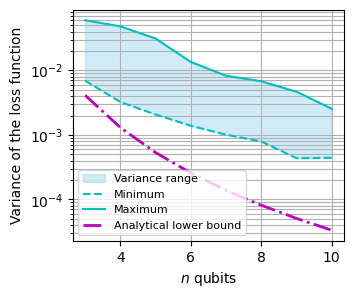

In [57]:
if __name__ == "__main__":
    # Parameters
    n_wires = 10
    n_graphs = 5
    max_depth = 30
    n_param_samples=100
    rng = np.random.default_rng(1234)
    # Compute variance bounds across n
    variance_bounds = empirical_variance_range_vs_n(n_min=3, n_max=10, max_depth=max_depth, n_param_samples=n_param_samples, rng=rng)
    
    # Plot variance range with reference curve
    plot_variance_range(
        variance_bounds,
        max_depth=low_depth,
        n_param_samples=n_param_samples,
        ref_scale = 1/3,
        outdir="./figures",
    )